In [1]:
import pandas as pd
from pylab import *
%matplotlib inline

import scrapenhl2.scrape.team_info as team_info
import scrapenhl2.scrape.teams as teams
import scrapenhl2.scrape.players as players
import scrapenhl2.scrape.autoupdate as autoupdate
import scrapenhl2.manipulate.manipulate as manip
import scrapenhl2.manipulate.add_onice_players as onice
# autoupdate.autoupdate()  # uncomment this to update data

The purpose of this script is to generate shot counts for skaters after faceoffs.

For example, CA after 5 and 10 seconds for Nicklas Backstrom after defensive-zone faceoff wins.

In [2]:
team = team_info.team_as_id('WSH')
season = 2017
pbp = teams.get_team_pbp(season, team)
toi = teams.get_team_toi(season, team)

This is how we'll approach the problem:

- Filter TOI to 5v5 and go wide to long on players
- Isolate faceoffs from the PBP
    - Get faceoff zones
    - Filter for 5v5
    - Get faceoff zones
- Join faceoffs to TOI and code how many seconds after a draw that sec is
    - Join faceoffs, have an indicator of last faceoff 
    - Fill forward on last faceoff time
    - Calculate difference between time and last faceoff time; filter for time <= 15
- Isolate shots from the PBP
    - Join to TOI
    - Filter for 5v5
    - Join to first dataframe on game, player, and time
    - Group by player, time since draw, draw zone and type, and which team took the shot, and sum
- Repeat for each team (not done here)

### 5v5 TOI

In [3]:
# Filter to 5v5
toi = manip.filter_for_five_on_five(toi) \
    [['Game', 'Team1', 'Team2', 'Team3', 'Team4', 'Team5', 'Time']] \
    .drop_duplicates()  # sometimes these appear
toi = toi.melt(id_vars=['Time', 'Game'], value_name='PlayerID') \
    .drop('variable', axis=1)
toi.head()

,Time,Game,PlayerID
0,0,20008,8475200.0
1,1,20008,8475200.0
2,2,20008,8475200.0
3,3,20008,8475200.0
4,4,20008,8475200.0


### Link times to time since last draw and faceoff zones

In [4]:
# Get faceoffs
draws = manip.filter_for_event_types(pbp, 'Faceoff')

# Select only needed columns
draws = draws[['Game', 'Team', 'Period', 'MinSec', 'X', 'Y']]

# Convert period and mm:ss to time elapsed in game
draws = onice.add_times_to_file(draws, periodcol='Period', timecol='MinSec', time_format='elapsed')
draws = draws.drop({'Period', 'MinSec'}, axis=1).assign(Season=season)

# Get zones
directions = manip.get_directions_for_xy_for_season(season, team)
draws = manip.infer_zones_for_faceoffs(draws, directions, 'X', 'Y', '_Secs', focus_team='WSH')
draws = draws.drop({'X', 'Y'}, axis=1)

# Simplify zone notation to just N, O, D
draws.loc[:, 'Zone'] = draws.FacLoc.str.slice(0, 1)
draws = draws.drop('FacLoc', axis=1)

# Combine with team column to change N, D, O, to NW, NL, DW, DL, OW, OL
draws.loc[:, 'WL'] = draws.Team.apply(lambda x: 'W' if x == team else 'L')
draws.loc[:, 'ZS'] = draws.Zone + draws.WL
draws = draws.drop({'WL', 'Zone', 'Team'}, axis=1)

draws.head()

,Game,_Secs,Season,ZS
0,20008,1,2017,NL
1,20008,330,2017,OL
2,20008,368,2017,DW
3,20008,386,2017,NW
4,20008,441,2017,DL


In [5]:
# Join to TOI
draws_joined = draws.rename(columns={'_Secs': 'Time'}) \
    .merge(toi, how='right', on=['Game', 'Time'])
    
# Add last faceoff indicator and fill forward
draws_joined = draws_joined.sort_values(['Game', 'PlayerID', 'Time'])
draws_joined.loc[pd.notnull(draws_joined.ZS), 'LastDraw'] = draws_joined.Time
draws_joined.loc[:, 'LastDraw'] = draws_joined[['Game', 'PlayerID', 'LastDraw']] \
    .groupby(['Game', 'PlayerID']).ffill()
draws_joined.loc[:, 'ZS'] = draws_joined[['Game', 'PlayerID', 'ZS']] \
    .groupby(['Game', 'PlayerID']).ffill()

draws_joined.loc[:, 'TimeSinceLastDraw'] = draws_joined.Time - draws_joined.LastDraw

draws_joined = draws_joined[pd.notnull(draws_joined.TimeSinceLastDraw)] \
    .query("TimeSinceLastDraw <= 15 & TimeSinceLastDraw > 0")

draws_joined.head()

,Game,Time,Season,ZS,PlayerID,LastDraw,TimeSinceLastDraw
5545,20008,369,NaN,DW,8468498.0,368.0,1.0
5550,20008,370,NaN,DW,8468498.0,368.0,2.0
5555,20008,371,NaN,DW,8468498.0,368.0,3.0
5560,20008,372,NaN,DW,8468498.0,368.0,4.0
5565,20008,373,NaN,DW,8468498.0,368.0,5.0


### Shot counts

In [6]:
# Get shot attempts
cfca = manip.filter_for_corsi(pbp)

# Select only needed columns
cfca = cfca[['Game', 'Team', 'Period', 'MinSec']]

# Convert period and mm:ss to time elapsed in game
cfca = onice.add_times_to_file(cfca, periodcol='Period', timecol='MinSec', time_format='elapsed')
cfca = cfca.drop({'Period', 'MinSec'}, axis=1).rename(columns={'_Secs': 'Time'})

# Add on-ice players
cfca = cfca.merge(toi, how='left', on=['Game', 'Time'])

# Change Team to CF or CA
cfca.loc[:, 'Team'] = cfca.Team.apply(lambda x: 'CF' if x == team else 'CA')

cfca.head()

,Game,Team,Time,PlayerID
0,20008,CF,46,8476344.0
1,20008,CF,46,8475758.0
2,20008,CF,46,8474291.0
3,20008,CF,46,8468498.0
4,20008,CF,46,8474590.0


In [7]:
# Join to faceoffs df
joined = draws_joined.merge(cfca, how='left', on=['Game', 'Time', 'PlayerID'])

# Get counts of time after each draw
time_counts = joined[['ZS', 'PlayerID', 'TimeSinceLastDraw']] \
    .assign(TOI=1) \
    .groupby(['ZS', 'PlayerID', 'TimeSinceLastDraw'], as_index=False) \
    .count()

# Get counts of shots
shot_counts = joined[['ZS', 'PlayerID', 'TimeSinceLastDraw', 'Team']] \
    .dropna() \
    .assign(Count=1) \
    .groupby(['ZS', 'PlayerID', 'TimeSinceLastDraw', 'Team'], as_index=False) \
    .count() \
    .pivot_table(index=['ZS', 'PlayerID', 'TimeSinceLastDraw'], columns='Team', values='Count') \
    .reset_index()
shot_counts.loc[:, 'CA'] = shot_counts.CA.fillna(0)
shot_counts.loc[:, 'CF'] = shot_counts.CF.fillna(0)

alljoined = time_counts \
    .merge(shot_counts, how='left', on=['ZS', 'PlayerID', 'TimeSinceLastDraw']) \
    .fillna(0)

alljoined.head()

,ZS,PlayerID,TimeSinceLastDraw,TOI,CA,CF
0,DL,8468498.0,1.0,50,0.0,0.0
1,DL,8468498.0,2.0,50,1.0,0.0
2,DL,8468498.0,3.0,48,2.0,0.0
3,DL,8468498.0,4.0,47,0.0,0.0
4,DL,8468498.0,5.0,48,7.0,0.0


Finally, we can replace Player IDs with names, export, and graph.

In [8]:
alljoined.loc[:, 'Player'] = players.playerlst_as_str(alljoined.PlayerID)
alljoined = alljoined.drop('PlayerID', axis=1)
alljoined.loc[:, 'CF60'] = alljoined.CF * 3600 / alljoined.TOI
alljoined.loc[:, 'CA60'] = alljoined.CA * 3600 / alljoined.TOI
alljoined.to_csv('time_since_last_draw_data.csv', index=False)
alljoined.head()

,ZS,TimeSinceLastDraw,TOI,CA,CF,Player,CF60,CA60
0,DL,1.0,50,0.0,0.0,Brooks Orpik,0.0,0.0
1,DL,2.0,50,1.0,0.0,Brooks Orpik,0.0,72.0
2,DL,3.0,48,2.0,0.0,Brooks Orpik,0.0,150.0
3,DL,4.0,47,0.0,0.0,Brooks Orpik,0.0,0.0
4,DL,5.0,48,7.0,0.0,Brooks Orpik,0.0,525.0


/Users/muneebalam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


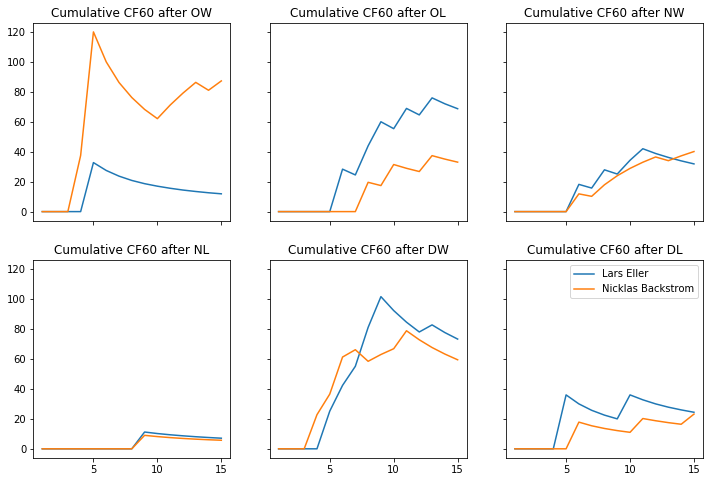

In [9]:
player1 = 'Lars Eller'
player2 = 'Nicklas Backstrom'

def plot_cumulative_shot_lines(df, zone, player1, player2, metric, ax):
    for p in (player1, player2):
        df1 = df.query('ZS == "{0:s}" & Player == "{1:s}"'.format(zone, p)).sort_values('TimeSinceLastDraw')
        df1.loc[:, 'TOI'] = df1.TOI.cumsum()
        df1.loc[:, metric] = df1[metric].cumsum()
        df1.loc[:, '{0:s}60'.format(metric)] = df1[metric] * 3600 / df1.TOI
        ax.plot(df1.TimeSinceLastDraw, df1['{0:s}60'.format(metric)], label=p)
    ax.set_title('Cumulative {0:s}60 after {1:s}'.format(metric, zone))

def plot_comparison(df, player1, player2, metric):
    fig, axes = subplots(2, 3, sharex=True, sharey=True, figsize=[12, 8])
    axes = axes.flatten()
    for i, zone in enumerate(['OW', 'OL', 'NW', 'NL', 'DW', 'DL']):
        plot_cumulative_shot_lines(df, zone, player1, player2, metric, axes[i])
        legend(loc=1)
        
plot_comparison(alljoined, player1, player2, 'CF')

/Users/muneebalam/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


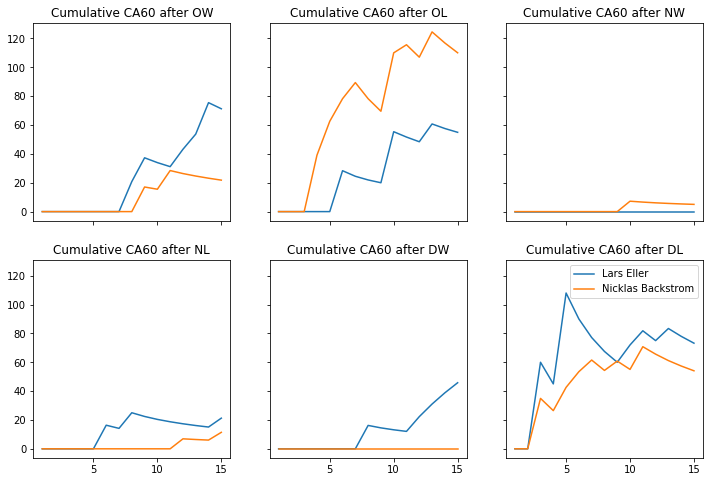

In [10]:
plot_comparison(alljoined, player1, player2, 'CA')